In [222]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sort import Sort
from functions import do_lines_intersect

In [223]:
def detect_red_hough(board):
    img_hsv=cv2.cvtColor(board, cv2.COLOR_RGB2HSV)

    # lower mask (0-10)
    lb = 60 #120
    lower_red = np.array([0,lb,lb])
    upper_red = np.array([9,255,255])
    mask0 = cv2.inRange(img_hsv, lower_red, upper_red)

    # upper mask (170-180)
    lower_red = np.array([160,lb,lb])
    upper_red = np.array([180,255,255])
    mask1 = cv2.inRange(img_hsv, lower_red, upper_red)

    k1 = np.ones((5,5))

    # join my masks
    redmask = mask0+mask1
    redmask = cv2.erode(redmask, k1)
    #redmask = cv2.erode(redmask, k1)
    #redmask = cv2.erode(redmask, k1)
    redmask = cv2.dilate(redmask, k1)
    redmask = cv2.dilate(redmask, k1)
    redmask = cv2.dilate(redmask, k1)
    redmask = cv2.dilate(redmask, k1)
    #redmask = cv2.dilate(redmask, k1)



    redboard = np.array(board)
    redboard[redmask==0] = 0
    redboard = cv2.cvtColor(redboard, cv2.COLOR_RGB2GRAY)
    redboard = cv2.equalizeHist(redboard)

    # redboard = cv2.cvtColor(redboard, cv2.COLOR_RGB2GRAY)

    minDist = 30
    param1 = 80 #canie threshold
    param2 = 28 #200 #smaller value-> more false circles
    minRadius = 30
    maxRadius = 40 #10

    circles = cv2.HoughCircles(redboard,cv2.HOUGH_GRADIENT, 1.2, minDist, param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)
    return circles,redboard


def detect_white_hough(board):
    epsilon = 34 #34 with equalization
    white_upper_range = np.array([255])
    white_lower_range = white_upper_range - epsilon

    k1 = np.ones((11,11))
    k2 = np.ones((7,7))
    
    board_ = cv2.cvtColor(board, cv2.COLOR_RGB2GRAY)
    board_ = cv2.equalizeHist(board_)

    whitemask = cv2.inRange(board_, white_lower_range, white_upper_range)

    whitemask = cv2.erode(whitemask, k1)
    #whitemask = cv2.erode(whitemask, k1)
    #whitemask = cv2.erode(whitemask, k2)

    whitemask = cv2.dilate(whitemask,k2)
    whitemask = cv2.dilate(whitemask,k2)
    whitemask = cv2.dilate(whitemask, k2)
    whitemask = cv2.dilate(whitemask, k2)

    whiteboard = np.array(board)
    whiteboard[whitemask==0] = 0
    whiteboard = cv2.cvtColor(whiteboard, cv2.COLOR_RGB2GRAY)

    minDist = 30
    param1 = 60 #60
    param2 = 25 #25 #smaller value-> more false circles
    minRadius = 30
    maxRadius = 40 #10

    circles = cv2.HoughCircles(whiteboard,cv2.HOUGH_GRADIENT, 1, minDist, param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)
    #circles = cv2.HoughCircles(whitemask,cv2.HOUGH_GRADIENT, 1.2, minDist, param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)
    return circles,whiteboard

def detect_dice(board):
    img_hsv=cv2.cvtColor(board, cv2.COLOR_RGB2HSV)

    lb = 50
    epsilon = 20
    lower_red = np.array([120-epsilon,lb,lb])
    upper_red = np.array([120+epsilon,255,255])
    mask0 = cv2.inRange(img_hsv, lower_red, upper_red)

    # plt.imshow(mask0)
    # plt.show()
    #mask0 = cv2.dilate(mask0, k)

    cnts = cv2.findContours(mask0, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    dice = []
    min_area = 500
    max_area = 1400
    for c in cnts:
        area = cv2.contourArea(c)
        if area > min_area and area < max_area:
            rect = cv2.minAreaRect(c)
            box = cv2.boxPoints(rect)
            box = box.astype(np.int64)
            x,y,w,h = cv2.boundingRect(c)
            
            p = 35
            epsilon = 20
            lower = np.array([120-epsilon,0,255-p])
            upper = np.array([120+epsilon,p,255])
            mask1 = cv2.inRange(img_hsv, lower, upper)

            # Width and height of the rectangle
            width = int(rect[1][0])
            height = int(rect[1][1])

            # Define target square size (max of width and height)
            size = max(width, height)

            # Destination points for warping
            dst_pts = np.array([[0, 0], [size - 1, 0], [size - 1, size - 1], [0, size - 1]], dtype="float32")

            # Compute the perspective transform matrix and apply it
            M = cv2.getPerspectiveTransform(np.float32(box), dst_pts)

            warped = cv2.warpPerspective(mask1, M, (size, size))

            # remove different sides of the dice
            warped = warped[1:size-1,1:size-1]

            keypoints, _ = cv2.findContours(warped, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if keypoints is None:
                keypoints = []
            min_area = 5
            max_area = 1000
            final_keypoints = [cnt for cnt in keypoints if min_area < cv2.contourArea(cnt) < max_area]

            #im_with_keypoints = cv2.drawContours(np.zeros(warped.shape), final_keypoints, -1, (255,0,0), 1)

            dice.append([len(final_keypoints), (x,y,w,h)])

    return dice


In [224]:
def detect_bar(board):
    gray = cv2.cvtColor(board, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5,5),0)
    blurred = cv2.blur(blurred, (5,5))

    # Detect circles using HoughCircles
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=5,
                            param1=50, param2=30, minRadius=1, maxRadius=20)

    bar_indicators = []

    # If circles are detected, draw them on the image
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            (R, G, B) = (int(board[y,x,0]),int(board[y,x,1]),int(board[y,x,2])) #!!! x and y places switched

            if G - max(B,R) > 10 and G > 60 and G < 210:
                bar_indicators.append((x,y))
    
    if len(bar_indicators) != 4:
        return None

    shortest_dist = 1000000

    # Find the shortest distance of 0 to any other detected point - it is used later for making the bounding rectangle a bit bigger to fit the bar better
    for idx in [1,2,3]:
        dist = abs(bar_indicators[idx][0] - bar_indicators[0][0]) + abs(bar_indicators[idx][1] - bar_indicators[0][1]) #L1 distance
        if dist < shortest_dist:
            shortest_dist = dist

    if shortest_dist > 200:
        return None

    x_centre = np.mean([x for (x,y) in bar_indicators])
    y_centre = np.mean([y for (x,y) in bar_indicators])

    new_bar_indicators = []
    for i in range(len(bar_indicators)):
        # Get points away from the ceter such that, we are enlarding the detection rectangle
        point = bar_indicators[i]

        new_point = [0,0]
        m = 0.4

        if point[0] > x_centre:
            new_point[0] = point[0] + int(m* shortest_dist)
        else:
            new_point[0] = point[0] - int(m* shortest_dist)

        if point[1] > y_centre:
            new_point[1] = point[1] + int(m* shortest_dist)
        else:
            new_point[1] = point[1] - int(m* shortest_dist)

        new_point = tuple(new_point)

        new_bar_indicators.append(new_point)

    return new_bar_indicators

def draw_lines(board, bar_indicators):
    rect = cv2.minAreaRect(np.array(bar_indicators))
    box = cv2.boxPoints(rect)
    box = np.intp(box)
    cv2.drawContours(board,[box],0,(0,0,255),2)


def is_point_inside_min_area_rect(rect, point):
    """
    Check if a point is inside the minAreaRect.

    Parameters:
        rect (tuple): The minAreaRect returned by cv2.minAreaRect.
        point (tuple): The point to check, given as (x, y).

    Returns:
        bool: True if the point is inside, False otherwise.
    """
    # Get the corners of the rectangle
    box = cv2.boxPoints(rect)  # Get the 4 corner points
    box = np.intp(box)         # Convert to integer coordinates

    # Use cv2.pointPolygonTest to determine if the point is inside
    result = cv2.pointPolygonTest(box, point, measureDist=False)

    # If result > 0, point is inside; if result == 0, point is on the edge; otherwise it's outside
    return result >= 0


def bar_drawing_handling(frame, old_bar_indicators, bar_indicators):
    if bar_indicators is not None:
        bar_rectangle = draw_lines(frame, bar_indicators)
        old_bar_indicators = bar_indicators

    elif old_bar_indicators is not None:
        bar_rectangle = draw_lines(frame, old_bar_indicators)
    
    else:
        return None, None

    return old_bar_indicators, bar_rectangle

done


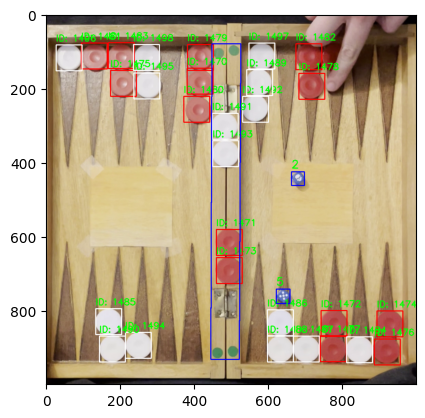

In [225]:
%matplotlib inline
cap = cv2.VideoCapture('videos/easy1.mp4')

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
size = 500
out1 = cv2.VideoWriter('output.mp4', fourcc, 30.0, (size,  size))
# out2 = cv2.VideoWriter('output_redmask.mp4', fourcc, 30.0, (size,  size))
# out3 = cv2.VideoWriter('output_whitemask.mp4', fourcc, 30.0, (size,  size))

red_tracker = Sort(max_age=150, iou_threshold=0.0000000000000001, min_hits=8)
 
white_tracker = Sort(max_age=150, iou_threshold=0.0000000000000001, min_hits=8)
j = 0

old_bar_indicators = None

throwing_dice = False
dice_score = None
consecutive_dices_threshold = 8
consecutive_dices = 0
 
while cap.isOpened():
    j+=1
    ret, frame = cap.read()

    f = 200
    if j < f:
        continue
    if j > f+1:
        break
    # if j > 600:
    #     break
 
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    frame = cv2.resize(frame, (1000,1000))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    dices = detect_dice(frame)

    dices_filtered = []
    for dice_tracked in dices:
        score, (x,y,w,h) = dice_tracked

        if old_bar_indicators is not None:
            bar_y_positions = [y for (x,y) in old_bar_indicators]
            if y > max(bar_y_positions) or y < min(bar_y_positions):
                continue
        dices_filtered.append(dice_tracked)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)
        cv2.putText(frame, f'{score}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    if not dices_filtered:
        throwing_dice = True
        dice_score = None
        consecutive_dices = 0

    if len(dices_filtered) >= 2:
        consecutive_dices += 1
    
    if consecutive_dices >= consecutive_dices_threshold:
        throwing_dice = False
        dice_score = sum([s for s, _ in dices_filtered])

    red_pawns, redboard = detect_red_hough(frame)
    red_detections = [[x-35, y-35, x + 35, y + 35, 1] for x, y, r in red_pawns[0, :]]

    if red_detections:
        red_tracked = red_tracker.update(np.array(red_detections))
    else:
        red_tracked = red_tracker.update()

    for obj in red_tracked:
        obj = np.uint16(np.around(obj))
        x_min, y_min, x_max, y_max, obj_id = obj

        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        cv2.putText(frame, f'ID: {int(obj_id)}', (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    white_pawns, whitemask = detect_white_hough(frame)
    white_detections = [[x-35, y-35, x + 35, y + 35, 1] for x, y, r in white_pawns[0, :]]

    if white_detections:
        white_tracked = white_tracker.update(np.array(white_detections))
    else:
        white_tracked = white_tracker.update()

    for obj in white_tracked:
        obj = np.uint16(np.around(obj))
        x_min, y_min, x_max, y_max, obj_id = obj

        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (255, 255, 255), 2)
        cv2.putText(frame, f'ID: {int(obj_id)}', (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    bar_indicators = detect_bar(frame)
    old_bar_indicators, bar_rectangle = bar_drawing_handling(frame, old_bar_indicators, bar_indicators)

    white_bar = 0
    red_bar = 0
    if bar_rectangle is not None:
        # for white in white_detections:
        #     point = (np.mean(white[0], white[2]), np.mean(white[1], white[3]))

        #     if is_point_inside_min_area_rect(bar_rectangle, point):
        #         white_bar += 1
        #         cv2.rectangle(frame, point, point, (0, 255, 0), 8)

        # for white in white_detections:
        #     point = (np.mean(white[1], white[3]), np.mean(white[0], white[2]))

        #     if is_point_inside_min_area_rect(bar_rectangle, point):
        #         white_bar += 1
        #         cv2.rectangle(frame, point, point, (255, 0, 0), 8)
        #         cv2.rectangle(frame, (x - 5, y - 5), (x + 5, y + 5), (255, 0, 0), -1)

        ...

    text = ''
    if throwing_dice:
        text = 'Throwing Dice'
    if not throwing_dice and dice_score is not None:
        text = f'Dice Sum: {dice_score}'

    cv2.putText(frame, f'{text}', (0,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    frame = cv2.resize(frame, (size,size))
    out1.write(frame)

    # redboard = cv2.resize(redboard, (size,size))
    # redboard = cv2.cvtColor(redboard, cv2.COLOR_GRAY2BGR)
    # out2.write(redboard)

    # whitemask = cv2.resize(whitemask, (size,size))
    # whitemask = cv2.cvtColor(whitemask, cv2.COLOR_GRAY2BGR)
    # out3.write(whitemask)
 
print('done')
cap.release()
out1.release()
# out2.release()
# out3.release()